In [58]:
import sys
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math


# Homework 3 from Martin Gräf, Richard Baumann and Thomas Block

## Exercise 1
Derive corresponding expressions for O[φ] for  magnetization (per site) and energy (per site). 





## Exercise 2

### Determine the equations of motion (EoMs) for this Hamiltonian by applying the Hamilton equations.

The Hamilton operator of the problem is given as:

\begin{equation}
    H=+\dfrac{p^2}{2}+\dfrac{{\varphi}^2}{2{\beta}\hat{J}}-N\ln\left(2\cosh\left({\varphi}+{\beta}h\right)\right).
\end{equation}

The equations of motion are given as:

\begin{equation}
    \dot{\varphi} = \dfrac{\partial}{\partial p} H = p
\end{equation}
\begin{equation}
    \dot{p} = -\dfrac{\partial}{\partial \varphi} H = 
    -\dfrac{{\varphi}}{{\beta}\hat{J}}+\dfrac{N\sinh\left({\varphi}+{\beta}h\right)}{\cosh\left({\varphi}+{\beta}h\right)}
\end{equation}

These can be implemented as:

In [106]:
# The artificial Hamiltonian as defined above
def hamiltonian_artificial(p , phi, N = 1, beta = 1, J = 1, h = 1):
    return ((p**2/2)+phi**2/(2*beta*J)-N*math.log(2*math.cosh(phi+beta*h)))

# phi dot as defined in the function above
def phi_dot(p , phi, N = 1, beta = 1, J = 1, h = 1):
    # both p and phi are two-element arrays.  phi doesn't do anything
    return p

# p dot as defined in the function above
def p_dot(p , phi, N = 1, beta = 1, J = 1, h = 1):
    # both p and phi are two-element arrays.  p doesn't do anything
    return (-(phi/(beta*J))+(N*math.sinh(phi+beta*h)/(math.cosh(phi+beta*h))))

## Exercise 3

Code up the leapfrog algorithm to evolve (p0, φ0) → (pf , φf ). Verify the convergence claim H(pf , φf ) = H(p0, φ0) + O(2). You should find something similar to Figure 1
(especially for large Nmd)

In [107]:

# Here could also be a parameter called trajLength, but on the exercise sheet
# it was given that this is supposed to be 1.
def leapfrog(p_start, phi_start, Nmd):
    p_end = p_start
    phi_end = phi_start
    
    # epsilon = trajLength/Nmd
    epsilon = 1/Nmd
    
    # first half step of the leap frog
    phi_end = phi_end + (epsilon/2) * phi_dot(p_end,phi_end)
    
    # now let the frogs jump. . .
    for i in range((Nmd)-1):
        p_end = p_end + epsilon*p_dot(p_end,phi_end)
        phi_end = phi_end + epsilon*phi_dot(p_end,phi_end)
        
    # now we've gone one step too far
    p_end = p_end + epsilon * p_dot(p_end,phi_end)
    phi_end = phi_end + (epsilon/2) * phi_dot(p_end,phi_end)
    
    return (p_end, phi_end)

print(leapfrog(1, 1, 1))
    


(0.4866142981514304, 1.7433071490757153)


Testing the leapfrog by making a polt for 

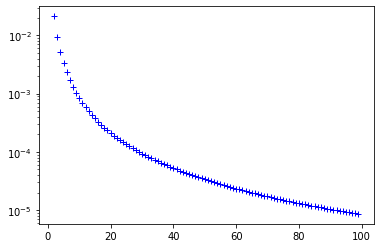

In [109]:
def test_leapfrog(p, phi):
    # Initilizing Variables, that will be used later
    # to calculate H(p_f, phi_f)
    p_f = phi_f = 0

    # Initilizing the arrays for future plotting
    # The Nmd array goes from 2 to 100, the H_array 
    # is the same length filled with zeros
    Nmd_array=np.arange(2, 100, 1)
    H_array=np.zeros(len(Nmd_array))

    # Calculating H(p_0, phi_0)
    energy_before=hamiltonian_artificial(p, phi)

    for i in range(len(H_array)):
        # Doing the leapfrog algorithm
        p_f, phi_f = leapfrog(p, phi, Nmd_array[i])

        # Calculating the energy after the leapfrog
        energy_after=hamiltonian_artificial(p_f, phi_f)

        # This is calculated to see, if the picture we get 
        # matches the picture from the exercise sheet.
        H_array[i]=(energy_after-energy_before)/energy_before
    plt.plot(Nmd_array, H_array, "b+", lw=1)
    plt.yscale("log")
    plt.savefig("pictures\leapfrog_test.png")

test_leapfrog(1, 1)

## Exercise 4
With your working leapfrog integrator, code up the HMC algorithm for the long-range Ising model.

## Exercise 5
Setting h = (βh) = .5 and using some values of N ranging from 5 to 20, calculate the average energy per site and mean magnetization per site as a function of J = (βJ) ∈ [.2, 2]. Tune Nmd such that the acceptance rate is above 50%